In [1]:
#basic libraries
import pandas as pd
import numpy as np

#file saving and format
import pickle
import ast

#SVD method
import sklearn
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer

#data visualization
import seaborn as sns
import matplotlib.pyplot as plt

#our functions
import functions  as fn

In [2]:
#Useful functions to save and load files in pickle format
def save_dict(obj, name ):
    with open(f'{name}.pickle', 'wb') as f:
        pickle.dump(obj, f)

def load_obj(name ):
    with open(f'{name}.pickle', 'rb') as f:
        return pickle.load(f)

## Import Data

In [54]:
data = pd.read_csv('Reviews.csv', usecols = ['ProductId','Summary','Text'])

In [55]:
data.head()

ProductId                Summary  \
0  B001E4KFG0  Good Quality Dog Food   
1  B00813GRG4      Not as Advertised   
2  B000LQOCH0  "Delight" says it all   
3  B000UA0QIQ         Cough Medicine   
4  B006K2ZZ7K            Great taffy   

                                                Text  
0  I have bought several of the Vitality canned d...  
1  Product arrived labeled as Jumbo Salted Peanut...  
2  This is a confection that has been around a fe...  
3  If you are looking for the secret ingredient i...  
4  Great taffy at a great price.  There was a wid...

In [56]:
#an example of a text that we will have to analyze
data.Text[6745]

"I love juice and I love carbonated beverages, but it is difficult to see this product having a long retail life.<br /><br />Essentially, this is a good drink that doesn't really do anything well.<br /><br />It doesn't taste good enough to be a juice replacement--and is there really a need for a juice replacement?  It might have limited value in camping situations or during other times where small cans make better travelers.<br /><br />It's not exactly a post-workout recovery drink.  Juice would be better.  Minute Maid juice, for instance, has less sugar and carbohydrates, even though Switch doesn't add any sugar.  And there are plenty of other juices that have more nutrients, including Calcium and other vitamins and supplements, including potassium.  So, it's less healthy than most juices.<br /><br />Switch isn't exactly a diet soda because of the natural sugar content comapared to zero sugar in diet drinks.<br /><br />As a regular alternative to sugared soda, it tastes good, but ther

# Analysis of the dataset

In [57]:
print(f'number of unique products: {len(data.ProductId.unique())} \nnumber of total rows in the dataset: {data.shape[0]}')

number of unique products: 74258 
number of total rows in the dataset: 568454


In [58]:
data.groupby('ProductId').count()

Summary  Text
ProductId                
0006641040       37    37
141278509X        1     1
2734888454        2     2
2841233731        1     1
7310172001      173   173
...             ...   ...
B009UOFTUI        1     1
B009UOFU20        1     1
B009UUS05I        1     1
B009WSNWC4        1     1
B009WVB40S        1     1

[74258 rows x 2 columns]

In [59]:
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   ProductId  568454 non-null  object
 1   Summary    568427 non-null  object
 2   Text       568454 non-null  object
dtypes: object(3)
memory usage: 13.0+ MB


## 1. Preprocessing

The first step in the analysis is the **pre-processing stage**.This  refers to the series of treatments that must be done to the corpus so that it's easier to analyze. The pre-processing part contains the following parts:
- **Corpus tokenization**, that is, divide the different texts into individual words.
- **Stop words removal**, which are common words (a, the, not, etc) that bring close to no contribution to the semantic meaning of a text
- **Noise removal** from the texts. This step will remove anything that can’t be recongnized as a english word, such as words with non ASCII symbols, words together with numbers, etc.
- **Stemming**, which reduces a word to it’s root. 
- **lower case and punctuation removal**

`wordlist = data['Text'].apply(lambda text: fn.pre_processing_data(text))`

`data['text_words'] = wordlist`

In [86]:
data.head(10)

ProductId                                        Summary  \
0  B001E4KFG0                          Good Quality Dog Food   
1  B00813GRG4                              Not as Advertised   
2  B000LQOCH0                          "Delight" says it all   
3  B000UA0QIQ                                 Cough Medicine   
4  B006K2ZZ7K                                    Great taffy   
5  B006K2ZZ7K                                     Nice Taffy   
6  B006K2ZZ7K  Great!  Just as good as the expensive brands!   
7  B006K2ZZ7K                         Wonderful, tasty taffy   
8  B000E7L2R4                                     Yay Barley   
9  B00171APVA                               Healthy Dog Food   

                                                Text  \
0  I have bought several of the Vitality canned d...   
1  Product arrived labeled as Jumbo Salted Peanut...   
2  This is a confection that has been around a fe...   
3  If you are looking for the secret ingredient i...   
4  Great taffy at a great price.  There was a wid...   
5  I got a wild hair for taffy and ordered this f...   
6  This saltwater taffy had great flavors and was...   
7  This taffy is so good.  It is very soft and ch...   
8  Right now I'm mostly just sprouting this so my...   
9  This is a very healthy dog food. Good for thei...   

                                          text_words  
0  [bought, sever, vital, can, dog, food, product...  
1  [product, arriv, label, jumbo, salt, peanut, p...  
2  [confect, around, centuri, light, pillowi, cit...  
3  [look, secret, ingredi, robitussin, believ, fo...  
4  [great, taffi, great, price, wide, assort, yum...  
5  [got, wild, hair, taffi, order, five, pound, b...  
6  [saltwat, taffi, great, flavor, soft, chewi, c...  
7  [taffi, good, soft, chewi, flavor, amaz, would...  
8  [right, mostli, sprout, cat, eat, grass, love,...  
9  [healthi, dog, food, good, digest, also, good,...

`data.to_csv('clean_dataset.csv')`

In [3]:
#to import directly the filtered dataset instead of pre-process everything again
data = pd.read_csv('clean_dataset.csv')
data.drop('Unnamed: 0',axis=1,inplace=True)

#to mantain the format of text_words as a list and not as a string
data['text_words'] = data['text_words'].map(ast.literal_eval)

## 2. Create a vocabulary with all the unique words from text_words
In this step we are going to take into account the last column of the dataset that contains the pre-processed words of each review. From this list of words we are going to create a useful dictionary that maps each unique term into an integer

`dictionary = fn.build_dictionary(data)`   -    to build

`save_dict(dictionary,'dictionary')` - to save

In [4]:
dictionary = load_obj('dictionary')   #to load it back

In [5]:
len(dictionary)

109234

## 3. For every unique product ID combine the list of words from different reviews together 
We noticed in our firts analysis that the number of unique products is much smaller than the number of rows in our dataframe. We so concluded that there were different reviews written by different users that refferred to the same exact product. We decided to group all these reviews together by creating a dictionary that will be saved and then recalled as **reviews_per_product** that has for:
- **keys** the product ID
- **values** a list of pre-processed words from all the different reviews of the same product

We will, as first thing, create two different lists: one that contains all the productsID of each row of the original dataset, and one, more important, that contains only the ID's of the unique products

In [6]:
products = list([data.ProductId[i] for i in range(len(data))])
unique_products = list(dict.fromkeys(products))

In [7]:
print(len(products))
print(len(unique_products))

568454
74258


`new_data = fn.union_of_reviews_for_same_product(unique_products, data)` - to build

`save_dict(new_data,'new_data')` - to save

In [10]:
reviews_per_product = load_obj('new_data') #to load

Going on with our initial analysis of the dataset that aims to prepare a final output that will be convenient for theimplementation of the K-Means algorithm, we wanto the calculate the frequence of each word for each productID

In [9]:
frequency_of_word = []
for key, item in reviews_per_product.items():
    frequency_of_words = Counter(item)
    frequency_of_word.append(frequency_of_words)

And then, we will use it to obtain the absolute frequence of each unique word, that we will savein a dictionary called **frequencies**

`freq = fn.frequency(dictionary,frequency_of_word)`

`save_dict(freq,'frequencies')` - to save

In [10]:
frequencies = load_obj('frequencies') #to load

Now we have all the elements to make some considerations: we noticed that, from the original vocabulary, we have **109234 unique words**. For the implementation of the algorithm, these words are too many. We want to find a way to reduce the number of words to consider by selecting only the ones that will be actually significant in the clusterization of the products

In [11]:
print('max: ',max(list(frequencies.values())))
print('min: ',min(list(frequencies.values())))

max:  288508
min:  1


In order to do so, we first filtered the list of words by removing the one that have a really low frequence (<20) since are words too unusual, technical or maybe they could be wrong words, with spelling mistakes, hence, with no meaning. At the same time we want to remove words. with a very high frequence (>200000) since these words are too common and will not help in dividing the products into similar groups, which is aour final goal.

In [12]:
output = fn.filter_words(frequencies)
useful_words = output[0] 
frequent_words = output[1]

In [13]:
dictionary_filtered = fn.new_dictionary(useful_words)

By doing this we will reduce the length of the dictionary that will contain all the different unique words found inside the reviews from `len(dictionary) = 109234 ` to `len(useful_words) = 14783 `

In [14]:
frequent_words

['product', 'good', 'tast', 'flavor', 'like']

As we can see above, all the words with very high frequencies are very common words, so they will not be useful in the determination of the cluster in which a certain review will belong.

## 4. Matrix product/word of occurrences

Now we want to create a matrix that will have the following structure:
- each column will represent one word from the list **useful_words**
- each row represents a different unique product id

Each **cell** of the matrix will represent the frequence of that certain word inside the reviews of that certain product

In [15]:
matrix = fn.get_occurrency_matrix(unique_products,dictionary_filtered,frequency_of_word)

In [16]:
matrix.shape

(74258, 14783)

## 5. Singular Value Decomposition   -- Mancano commenti !

Now that we have a first reduction of the significat words, we want to apply the **SVD Method** to further reduce them, while, at the same time, we still have a high level of variance explained by those words

In [17]:
svd = TruncatedSVD(n_components = 70,n_iter=3, random_state=42)
svd.fit(matrix)

TruncatedSVD(n_components=70, n_iter=3, random_state=42)

In [18]:
explained_variance = svd.explained_variance_ratio_.sum()
print("Explained variance: {}%".format(int(explained_variance * 100)))

Explained variance: 88%


In [19]:
svd.singular_values_

array([14075.00253347,  9413.25706533,  6734.25180712,  5593.33577997,
        5539.76174193,  5249.7451622 ,  4378.87047079,  4032.09614654,
        3456.09734606,  3418.55319786,  3357.42962126,  3186.46297676,
        3067.33956656,  2782.73423913,  2678.44738894,  2519.12922409,
        2451.48136771,  2382.96275717,  2339.29002079,  2277.59562985,
        2203.46565703,  2132.83968298,  2100.65074326,  2030.53314251,
        1994.15609593,  1948.34557693,  1826.07998537,  1824.355337  ,
        1742.77630262,  1701.32821232,  1657.0294025 ,  1623.15721698,
        1598.5235173 ,  1573.66713731,  1525.36188704,  1493.53634565,
        1430.13540424,  1421.36081194,  1415.599189  ,  1363.01988048,
        1346.31793295,  1319.0535977 ,  1297.21211006,  1269.78049718,
        1258.41771806,  1243.83254532,  1214.95852137,  1202.49387618,
        1196.8748276 ,  1176.01779192,  1156.56578966,  1146.07727435,
        1124.06907974,  1119.77834732,  1106.03435039,  1090.0859083 ,
      

In [21]:
components = svd.components_
features = useful_words

In [22]:
relevant_words = fn.get_relevant_words(components, features)
print(relevant_words)

['new', 'pretti', 'prefer', 'nice', 'decaf', 'howev', 'cereal', 'use', 'care', 'dark', 'anyth', 'wonder', 'bold', 'feel', 'bite', 'mountain', 'guess', 'dog', '6', 'goe', 'hand', 'fat', 'green', 'probabl', 'similar', 'want', 'bake', 'perfect', 'full', '4', 'teeth', 'soda', 'can', 'open', 'extra', 'eat', 'stuff', 'peopl', 'great', 'end', 'keurig', 'rather', 'thought', 'problem', 'drink', 'senseo', 'carri', 'fan', 'although', 'would', 'add', 'plu', 'think', 'definit', 'left', 'mouth', 'ship', 'anyon', 'pot', 'whole', 'still', 'go', 'item', 'meal', 'found', 'figur', 'spice', 'meat', 'three', 'actual', 'cat', 'result', 'way', 'experi', 'excel', 'side', 'famili', 'lot', 'mani', 'make', 'diet', 'grain', 'someth', 'say', 'daili', 'skin', 'stomach', 'made', 'fresh', 'honey', 'cours', 'surpris', 'sweet', 'week', 'noth', 'juic', 'packet', 'decid', 'slightli', 'real', 'day', 'ginger', 'said', 'store', 'fruit', 'morn', 'pick', 'brew', 'four', 'wife', 'least', 'start', 'conveni', 'next', 'acid', 'si

After selcting the most relevant words out of the total of unique words found, we have to update the dictionary **reviews_per_product** which associates a list of preprocessed words found in all the reviews concerning the same product, to the ProductID corresponding. The list now should contain only the words that were found in the reviews **AND** are inside the list of **relevant_words** that we extracted

In [23]:
#to update the dictionary reviews_per_product
for key, value in reviews_per_product.items():
    reviews_per_product[key] = [word for word in value if word in relevant_words]

We need of course to calculate again the frequency of those words...

In [24]:
frequency_of_word = []
for key, item in reviews_per_product.items():
    frequency_of_words = Counter(item)
    frequency_of_word.append(frequency_of_words)

... And create a final dictionary that maps those relevant words into integers

In [25]:
final_dictionary = fn.new_dictionary(relevant_words) 

## 6. Calculate Tf-Idf Scores for each word inside the reviews of a product ID

`tf_score = fn.tf(frequency_of_word,reviews_per_product)`

`idf_score = fn.idf(relevant_words,frequency_of_word,reviews_per_product)`

`tf_idf_scores = fn.tf_idf_score(tf_score,idf_score,reviews_per_product)`

`save_dict(tf_idf_scores,'tf_idf_scores')` - to save

In [26]:
tf_idf_scores = load_obj('tf_idf_scores')   #to load

In [27]:
#an example of the final output
tf_idf_scores[0]

{'bought': 0.10921,
 'sever': 0.16207,
 'can': 0.22032,
 'dog': 0.19854,
 'food': 0.11283,
 'found': 0.11182,
 'qualiti': 0.13776,
 'look': 0.10748,
 'meat': 0.22029,
 'smell': 0.17404,
 'better': 0.20642}

## 7. Creation of the final dataframe that consider the TF-IDF scores and will be used for the implementation of K-Means :
We will first initialize a matrix that will have as many rows as the number of unique product ID's that we have and as many columns as the number of relevant words that we found.

For each product we will assign a score to each word:
- 0 if the word is not found inside the list of words of the reviews of that product
- tf-idf score of that word otherwise

In [29]:
product_vector = get_tfidf_scores_matrix(unique_products,relevant_words, tf_idf_scores, final_dictionary)

In [30]:
#trial to see if the above operation worked

indices = (np.where(product_vector[0] != 0))[0]
print(indices,'\n')

for elem in indices:
    for key in final_dictionary.keys():
        if final_dictionary[key] == elem:
            print(key)

print('\n',reviews_per_product[unique_products[0]])           

[ 17  32  64  67 154 263 283 348 358 422 456] 

dog
can
found
meat
food
sever
better
smell
look
qualiti
bought

 ['bought', 'sever', 'can', 'dog', 'food', 'found', 'qualiti', 'look', 'meat', 'smell', 'better', 'better']


Finally, we can convert the result into a dataframe:

In [31]:
d = pd.DataFrame(product_vector, index = unique_products, columns = relevant_words)
d

new  pretti   prefer  nice  decaf  howev   cereal      use  care  \
B001E4KFG0  0.0     0.0  0.00000   0.0    0.0    0.0  0.00000  0.00000   0.0   
B00813GRG4  0.0     0.0  0.00000   0.0    0.0    0.0  0.00000  0.00000   0.0   
B000LQOCH0  0.0     0.0  0.00000   0.0    0.0    0.0  0.00000  0.00000   0.0   
B000UA0QIQ  0.0     0.0  0.00000   0.0    0.0    0.0  0.00000  0.00000   0.0   
B006K2ZZ7K  0.0     0.0  0.00000   0.0    0.0    0.0  0.00000  0.00000   0.0   
...         ...     ...      ...   ...    ...    ...      ...      ...   ...   
B000H7K114  0.0     0.0  0.00000   0.0    0.0    0.0  0.00000  0.06411   0.0   
B001EO7N10  0.0     0.0  0.02228   0.0    0.0    0.0  0.00000  0.04481   0.0   
B003S1WTCU  0.0     0.0  0.00000   0.0    0.0    0.0  0.00000  0.04630   0.0   
B004I613EE  0.0     0.0  0.00000   0.0    0.0    0.0  0.00000  0.00000   0.0   
B001LR2CU2  0.0     0.0  0.00000   0.0    0.0    0.0  0.83609  0.20836   0.0   

            dark  ...     gave  call  cooki       ad  larg  health  coupl  \
B001E4KFG0   0.0  ...  0.00000   0.0    0.0  0.00000   0.0     0.0    0.0   
B00813GRG4   0.0  ...  0.00000   0.0    0.0  0.00000   0.0     0.0    0.0   
B000LQOCH0   0.0  ...  0.00000   0.0    0.0  0.00000   0.0     0.0    0.0   
B000UA0QIQ   0.0  ...  0.00000   0.0    0.0  0.00000   0.0     0.0    0.0   
B006K2ZZ7K   0.0  ...  0.00000   0.0    0.0  0.00000   0.0     0.0    0.0   
...          ...  ...      ...   ...    ...      ...   ...     ...    ...   
B000H7K114   0.0  ...  0.00000   0.0    0.0  0.00000   0.0     0.0    0.0   
B001EO7N10   0.0  ...  0.02396   0.0    0.0  0.02005   0.0     0.0    0.0   
B003S1WTCU   0.0  ...  0.00000   0.0    0.0  0.00000   0.0     0.0    0.0   
B004I613EE   0.0  ...  0.00000   0.0    0.0  0.00000   0.0     0.0    0.0   
B001LR2CU2   0.0  ...  0.00000   0.0    0.0  0.00000   0.0     0.0    0.0   

             chocol   bought    littl  
B001E4KFG0  0.00000  0.10921  0.00000  
B00813GRG4  0.00000  0.00000  0.00000  
B000LQOCH0  0.00000  0.00000  0.00000  
B000UA0QIQ  0.00000  0.00000  0.00000  
B006K2ZZ7K  0.00000  0.00000  0.00000  
...             ...      ...      ...  
B000H7K114  0.00000  0.00000  0.00000  
B001EO7N10  0.00000  0.00000  0.01233  
B003S1WTCU  0.11909  0.00000  0.00000  
B004I613EE  0.00000  0.00000  0.02798  
B001LR2CU2  0.00000  0.00000  0.00000  

[74258 rows x 458 columns]

And we will save it so that we can import only this final step since it contains everything we need for the implementation of the K-Means Algorithm

`d.to_csv('tf_idf_scores_dataframe.csv')` - to save

# K-means

In [3]:
d = pd.read_csv('tf_idf_scores_dataframe.csv')
d.set_index('Unnamed: 0',inplace=True)
d.head()

new  pretti  prefer  nice  decaf  howev  cereal  use  care  dark  \
Unnamed: 0                                                                     
B001E4KFG0  0.0     0.0     0.0   0.0    0.0    0.0     0.0  0.0   0.0   0.0   
B00813GRG4  0.0     0.0     0.0   0.0    0.0    0.0     0.0  0.0   0.0   0.0   
B000LQOCH0  0.0     0.0     0.0   0.0    0.0    0.0     0.0  0.0   0.0   0.0   
B000UA0QIQ  0.0     0.0     0.0   0.0    0.0    0.0     0.0  0.0   0.0   0.0   
B006K2ZZ7K  0.0     0.0     0.0   0.0    0.0    0.0     0.0  0.0   0.0   0.0   

            ...  gave  call  cooki   ad  larg  health  coupl  chocol   bought  \
Unnamed: 0  ...                                                                 
B001E4KFG0  ...   0.0   0.0    0.0  0.0   0.0     0.0    0.0     0.0  0.10921   
B00813GRG4  ...   0.0   0.0    0.0  0.0   0.0     0.0    0.0     0.0  0.00000   
B000LQOCH0  ...   0.0   0.0    0.0  0.0   0.0     0.0    0.0     0.0  0.00000   
B000UA0QIQ  ...   0.0   0.0    0.0  0.0   0.0     0.0    0.0     0.0  0.00000   
B006K2ZZ7K  ...   0.0   0.0    0.0  0.0   0.0     0.0    0.0     0.0  0.00000   

            littl  
Unnamed: 0         
B001E4KFG0    0.0  
B00813GRG4    0.0  
B000LQOCH0    0.0  
B000UA0QIQ    0.0  
B006K2ZZ7K    0.0  

[5 rows x 458 columns]

Before applying the algorithm, we need to understand **K**, the number of clusters. This can be determined by the **elbow method**

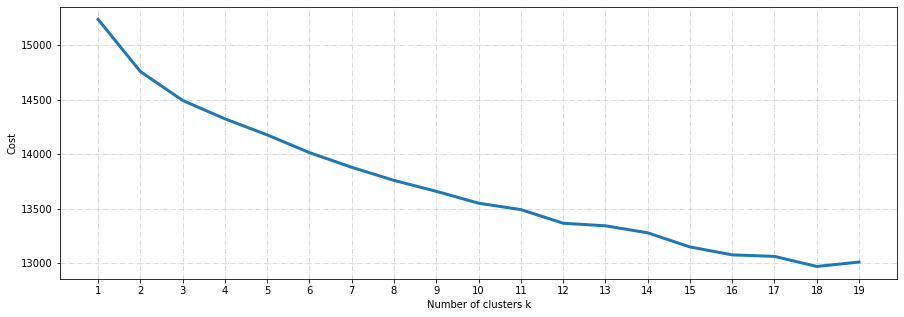

The optimal number of clusters is: 10


In [4]:
k = fn.elbow_method(d)
print(f'The optimal number of clusters is: {k}')

We decided to select the best k using the following condition: we want the minimun number of clusters that explains at least 80% of  the variance of the curve. The variance explained with the best k should be minimum: $\textrm{variance with } k=1 - [(\textrm{variance with } k = 1) - (\textrm{variance with } k = 20)]*0.8$

In [5]:
#we convert our initial dataframe d into an array for easier computation
vectors = np.array(d)

We first define some functions that will be then recalled inside the proper algorithm: this functions will be useful to determine the initial points of each cluster, compute the distance between each point and each cluster, in order to understand in which cluster that point has to be inserted, and, finally, compute the variance at each iteration of the algorthm in order to understand when the best cluster is achieved.

In [6]:
initial_centroids, centroids, clusters, cluster_variance = fn.k_means(vectors,d,k)

INITIALIZATION

our initial centroids are the products:

B0039K6YF8
B002G8T3MA
B001SAZII0
B008MZGFE0
B000H155VQ
B004I10TDK
B004RZZLYE
B004538TME
B0000CNU0W
B0014ET2UU

iteration 0: cluster variance: 1483.3

ITERATIONS

iteration 1: cluster variance 1457.3
iteration 2: cluster variance: 1445.2
iteration 3: cluster variance: 1434.6
iteration 4: cluster variance: 1422.3
iteration 5: cluster variance: 1407.8
iteration 6: cluster variance: 1396.0
iteration 7: cluster variance: 1387.7
iteration 8: cluster variance: 1384.3
iteration 9: cluster variance: 1382.7


We know that, when the cluster variance pretty much stabilize, it means that the algorithm has found the best solution: the data points within each cluster stop changing. So, to take into account this phenomenon, we inserted a condition that considers the distance between the variation at step *i* and at step *i-1*, when it goes below a certain limit (that we fixed at 1.0), the algorithm stops.

We can visualize the change of viariance at each iteration from the graph below:

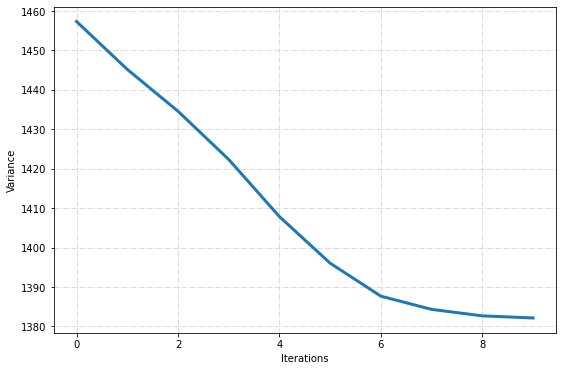

In [7]:
plt.figure(figsize=(9,6))
plt.plot(cluster_variance, linewidth = 3)
plt.grid(color = 'lightgray', linestyle = '-.')
plt.xlabel('Iterations')
plt.ylabel('Variance')
plt.show()

We will now create a new dataframe that has only three columns:
1. the **Product ID**
2. the **list of words** associated to the reviews of that specif product
3. the **cluster** in which that product has been assigned from the K-Means algorithm

In [8]:
cluster_list = [cluster for list in clusters for cluster in list]

In [11]:
df = pd.DataFrame(list(reviews_per_product.items()),columns = ['ProductID','list_of_words']) 
df['cluster'] = cluster_list

This new dataframe will be used in the analysis of the clusters, which is the next step of our project

# Analysis of the clusters

Since we can retrieve the product Id of the prooducts inside the same cluster, we can now analyze the clusters a little bit deeper.

To do so we will need the newdataframe that wehave create **df** and the original dataset **Reviews** that contains more information for each row

In [12]:
data = pd.read_csv('Reviews.csv')
data.drop('Id', axis = 1, inplace = True)
data.head()

ProductId          UserId                      ProfileName  \
0  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...  
3         Cough Medicine  If you are looking for the secret ingredient i...  
4            Great taffy  Great taffy at a great price.  There was a wid...

### 1. Identify the kind of products in the cluster (e.g., chips, tea, coffee) using a word cloud.

Word cloud for cluster: 1


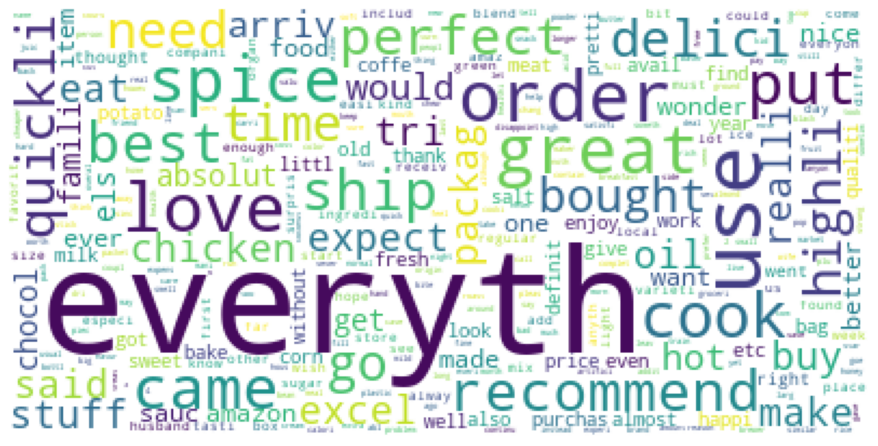

Word cloud for cluster: 2


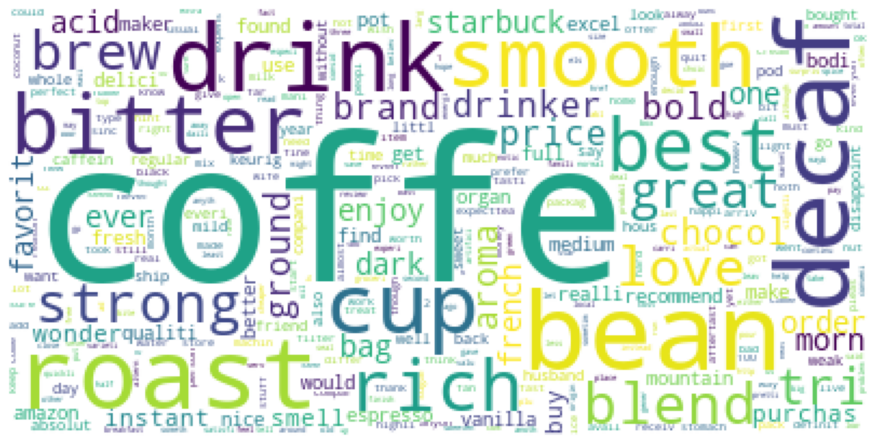

Word cloud for cluster: 3


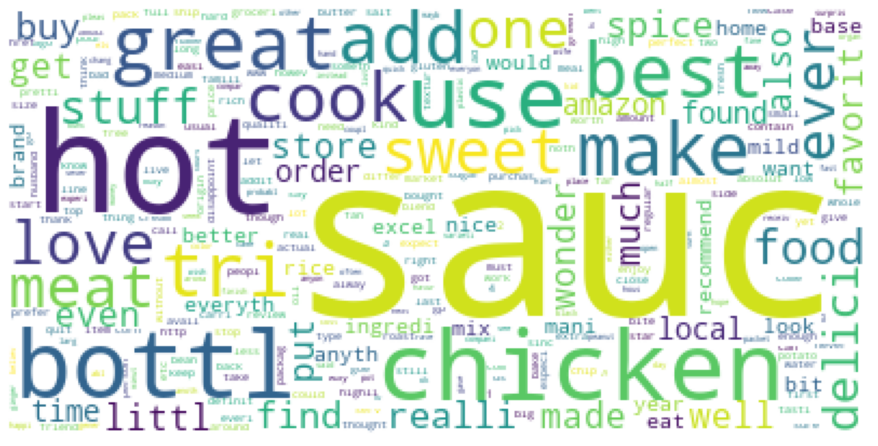

Word cloud for cluster: 4


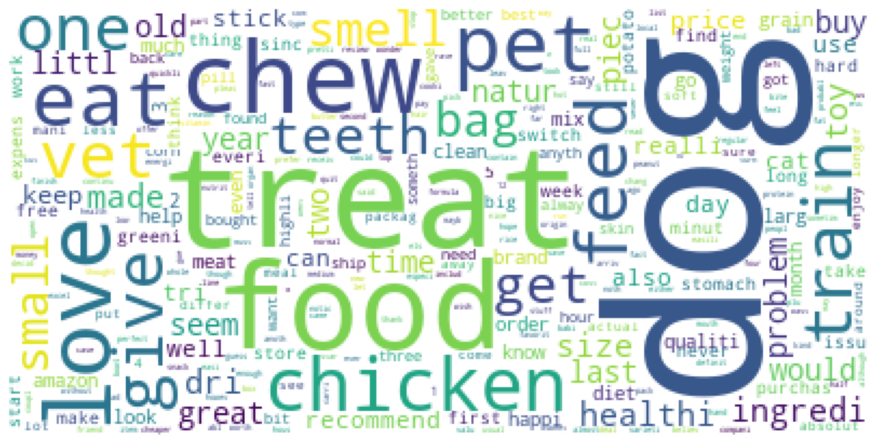

Word cloud for cluster: 5


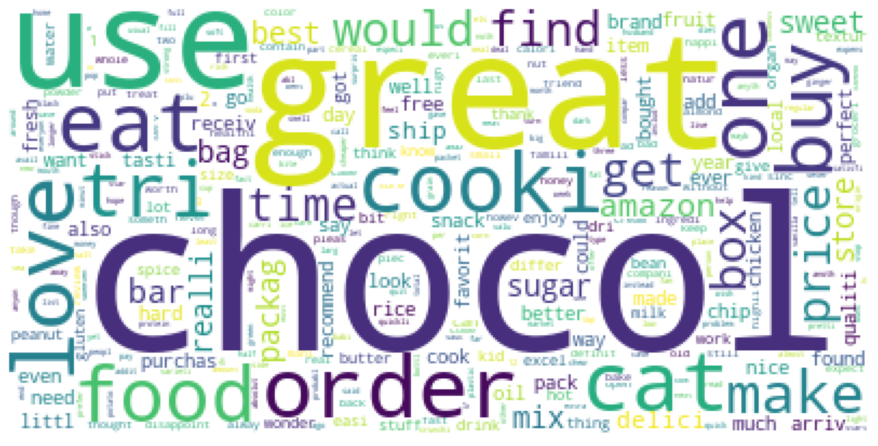

Word cloud for cluster: 6


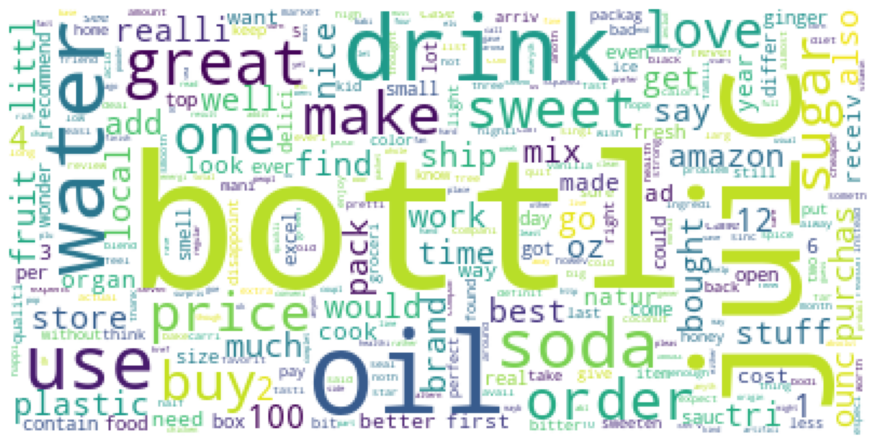

Word cloud for cluster: 7


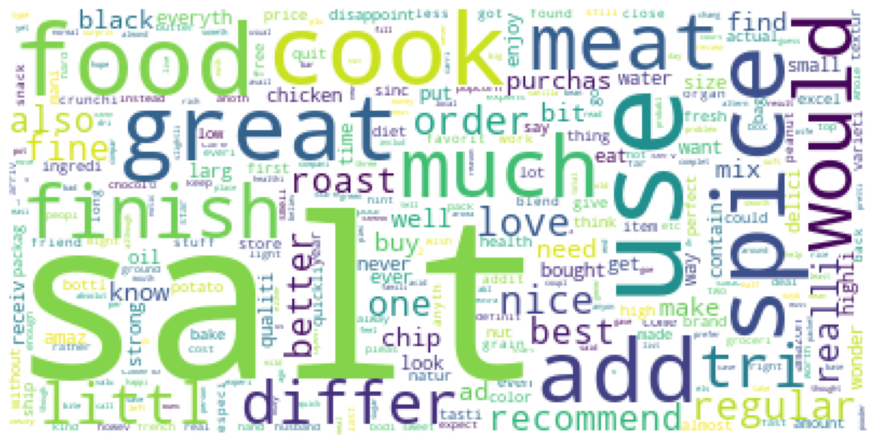

Word cloud for cluster: 8


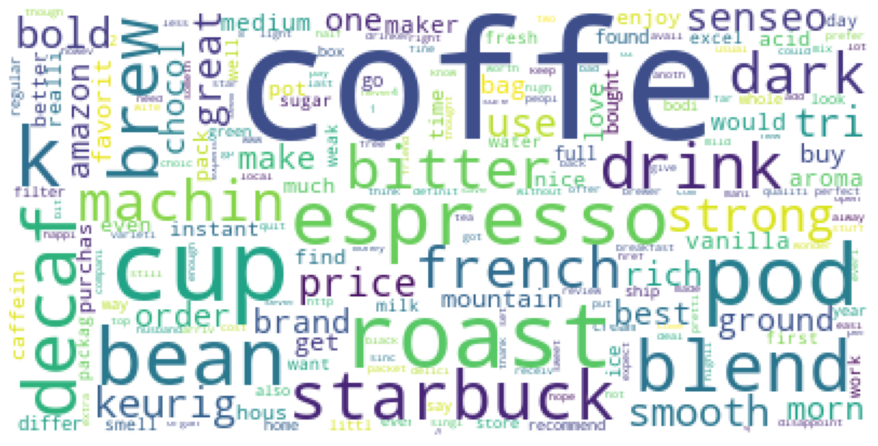

Word cloud for cluster: 9


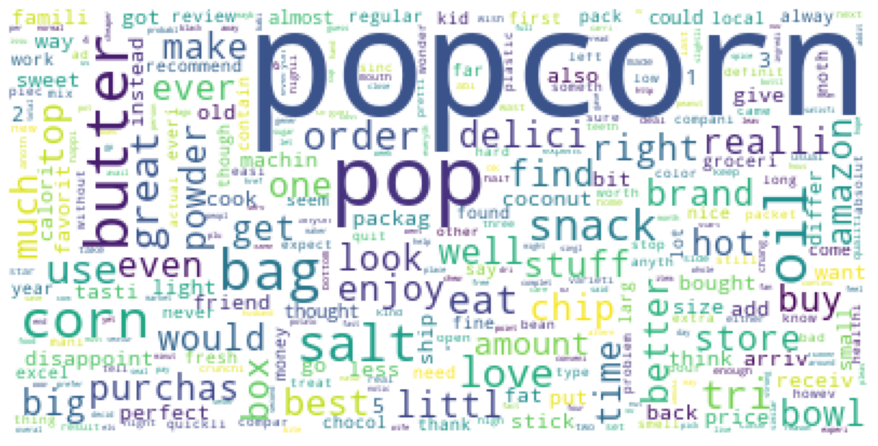

Word cloud for cluster: 10


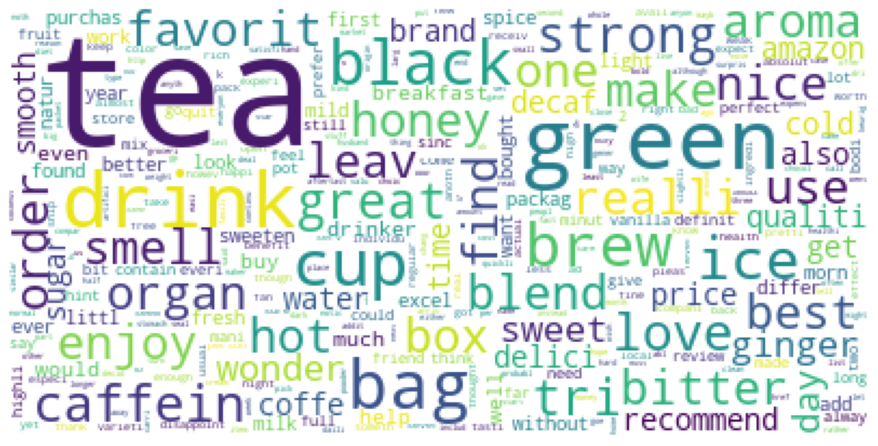

In [13]:
fn.words_cloud(d,k,cluster_list)

### 2. Provide the number of product in each cluster:
We have already answered this question above, when we grouped by the products based on the cluster they belonged. We are going to show again the final result here:

In [14]:
df.groupby('cluster').count()

ProductID  list_of_words
cluster                          
1              338            338
2             1286           1286
3             2039           2039
4             4437           4437
5            53254          53254
6             2242           2242
7             1054           1054
8             3729           3729
9              510            510
10            5369           5369

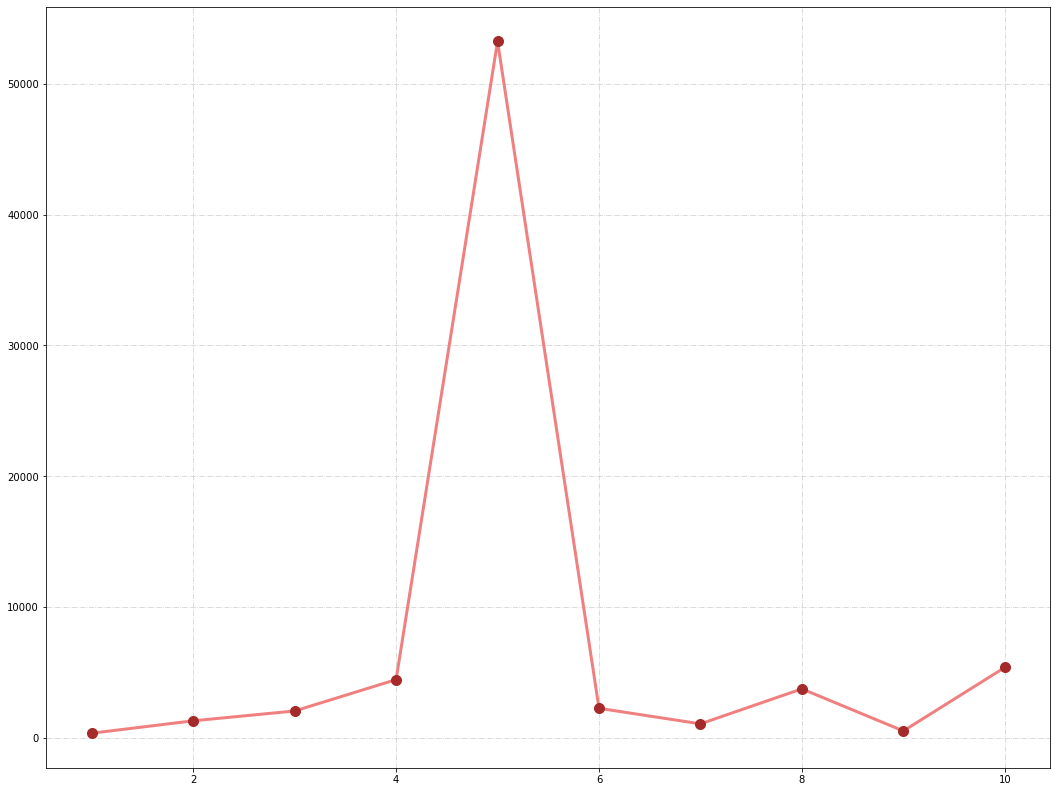

In [15]:
plt.figure(figsize = (18,14))
plt.plot(df.groupby('cluster').ProductID.count(), color = 'lightcoral',linewidth = 3, 
         marker = 'o', markersize = 10, mfc = 'brown', mec = 'brown')
plt.grid(color = 'lightgray', linestyle = '-.')
plt.rcParams['axes.facecolor'] = 'whitesmoke'
plt.show()

As we can see, the algorithm that has the majoriry of products associated to, is **cluster number 6** which corrresponds to the following product IDs:

In [16]:
df[df.cluster == 5].ProductID

2        B000LQOCH0
3        B000UA0QIQ
4        B006K2ZZ7K
5        B000E7L2R4
8        B0009XLVG0
            ...    
74251    B000NY8O9M
74252    B006T7TKZO
74254    B001EO7N10
74255    B003S1WTCU
74257    B001LR2CU2
Name: ProductID, Length: 53254, dtype: object

And we can also generate a word cloud to see specifically the most common words in this cluster:

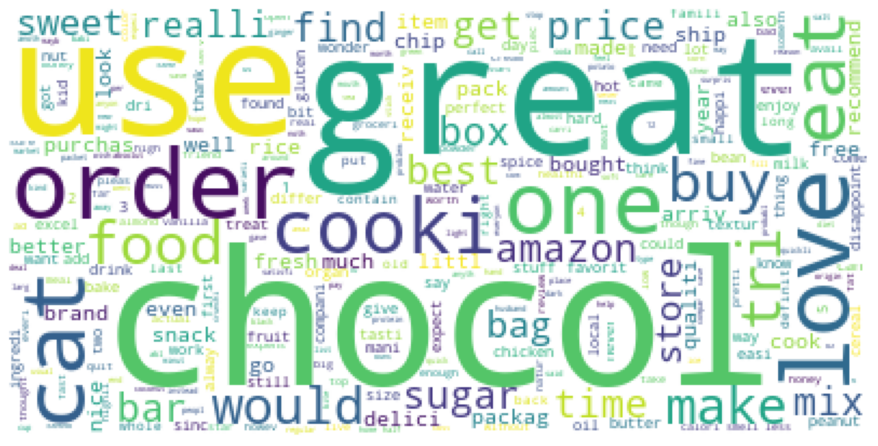

In [17]:
fn.one_word_cloud(5,d)

### 3. Compute the reviews' score distribution in each cluster

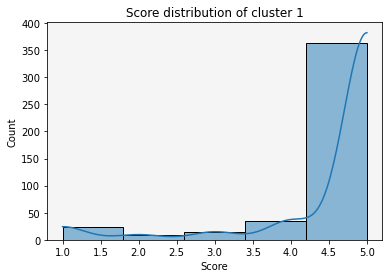

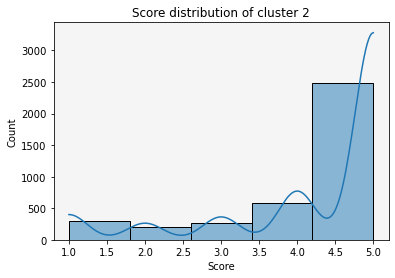

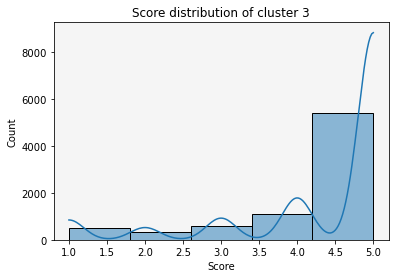

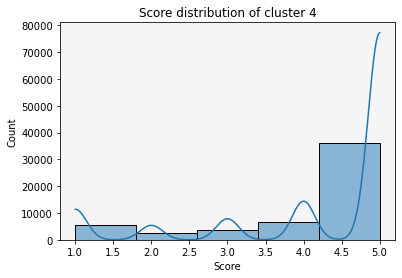

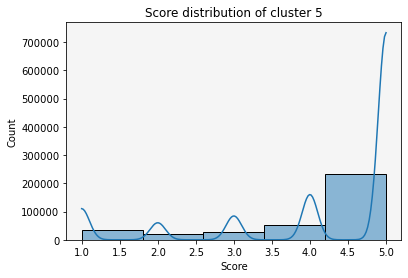

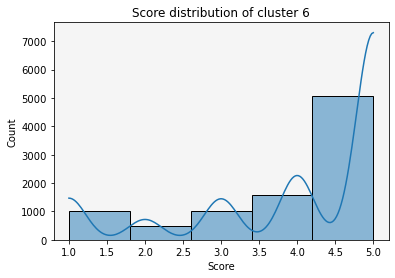

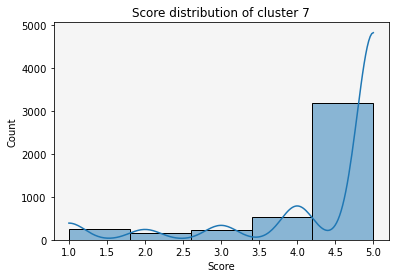

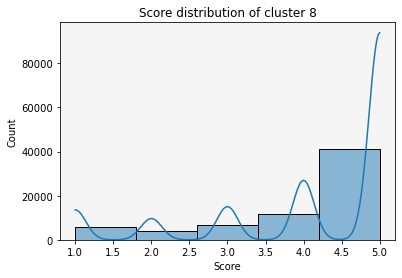

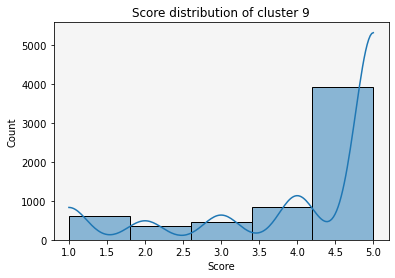

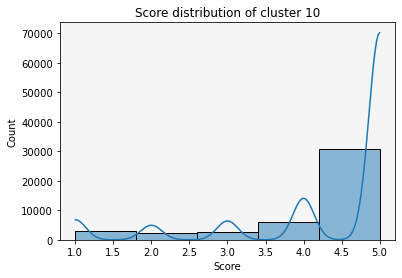

In [36]:
score_means = fn.review_score_distribution(k,df,data)

In [33]:
for i in range(1,len(score_means)+1):
    print(f'mean of scores in cluster {i}: {round(score_means[i-1],3)}')

print(f'\nThe maximum value is: {round(max(score_means),3)} while the minimum is: {round(min(score_means),3)}')

mean of scores in cluster 1: 4.591
mean of scores in cluster 2: 4.235
mean of scores in cluster 3: 4.335
mean of scores in cluster 4: 4.21
mean of scores in cluster 5: 4.172
mean of scores in cluster 6: 4.001
mean of scores in cluster 7: 4.431
mean of scores in cluster 8: 4.119
mean of scores in cluster 9: 4.144
mean of scores in cluster 10: 4.327

The maximum value is: 4.591 while the minimum is: 4.001


As we can see, although the number of products in each cluster in extremely different, the mean of the scores that the users give to the products in each cluster is basically the same, and is a very high value, always greater than 4

### 4. Get the number of unique users writing reviews in each cluster 

In [34]:
fn.number_of_unique_users(k, df, data)

number of unique users writing reviews in cluster 1: 421
number of unique users writing reviews in cluster 2: 3433
number of unique users writing reviews in cluster 3: 6303
number of unique users writing reviews in cluster 4: 20915
number of unique users writing reviews in cluster 5: 184121
number of unique users writing reviews in cluster 6: 7220
number of unique users writing reviews in cluster 7: 2587
number of unique users writing reviews in cluster 8: 31851
number of unique users writing reviews in cluster 9: 3482
number of unique users writing reviews in cluster 10: 22952
